In [14]:
import j_models.j_models as j_models

In [12]:
# %pdb
%load_ext autoreload
%autoreload 2
path = 'data/'
pd.set_option('display.max_columns', 500)
debug=False
import itertools as itertools
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.cache_size = 0
from tqdm import tqdm
tqdm.monitor_interval = 0
pd.set_option('max_columns', 999)
from sklearn.ensemble import RandomForestClassifier
sys.path.append('/home/justin/fmpytorch/')
from fmpytorch.second_order.fm import FactorizationMachine
from sklearn.metrics import log_loss

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def make_data1(n_datapoints):
    df = pd.DataFrame(columns=['cat1', 'cat2', 'cont1', 'cont2'])
    n_rows = n_datapoints**2
    df['cat1'] = np.random.choice(np.arange(4), n_rows)
    df['cat2'] = np.random.choice(np.arange(4), n_rows)
    df['cont1'] = np.random.normal(size=n_rows)
    df['cont2'] = np.random.normal(size=n_rows)
    y = np.where(df['cat1'] == 1, 1,
               np.where(df['cont1'] < df['cont2'], 1,
                np.where((df['cat2'] == 0) & (df['cont1'] + df['cont2'] >=
                          1.2), 1, 0)))
    noise_probs = np.random.binomial(1, .05, len(y))
    y = y.astype(bool)
    print(y.sum())
    y[noise_probs==1] = np.logical_not(y[noise_probs==1])
    print(y.sum())
    y = y.astype(int)
    return df, y

def make_data2(n_datapoints):
    x = np.linspace(0,10,num=n_datapoints)
    y = np.linspace(0,10,num=n_datapoints)
    X, Y = np.meshgrid(x,y)
    pnts = np.array(list(zip(np.ravel(X), np.ravel(Y))))
    def fun(a):
        x,y = a[0], a[1]
        return x + 2*np.cos(x) + y + 2*np.sin(-y)
    zs = np.apply_along_axis(fun, 1, pnts)
    noise = np.random.normal(scale=.2, size=X.shape)
    Z = zs.reshape(X.shape)
    Z = Z + noise
    return X,Y,Z

In [3]:
is_reg = False
n_datapoints=1000
if not is_reg:
    df, y = make_data1(n_datapoints)
    cat_flds = ['cat1', 'cat2']
    is_reg = False
    out_sz = 2
else:
    X,Y,Z = make_data2(n_datapoints)
    df, y = pd.DataFrame(data={'x1':np.ravel(X), 'x2':np.ravel(Y)}), np.ravel(Z)
    cat_flds = []
    is_reg = True
    out_sz = 1

642611
628389


In [4]:
%matplotlib notebook
if is_reg:
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(X = X, Y = Y, Z = Z)

In [5]:
val_idxs = get_cv_idxs(len(df))
val_idxs.sort()

In [6]:
# for regression I want to use root mean squarred log error, if there are neatives I need to translate all values to be positive
if is_reg:
    if y[y<0].sum() != 0:
        orig_y = y.copy()
        epsilon = 1e-6
        total_shift = abs(y.min()) + max(abs(y.min()), epsilon)
        y = y + total_shift

In [7]:
y.min(), y.max()

(0, 1)

In [8]:
if is_reg:
    data = ColumnarModelData.from_data_frame(path, val_idxs, df, y, cat_flds, bs=128*4, is_reg=is_reg, is_multi=False, test_df = df)
else:
    data = ColumnarModelData.from_data_frame(path, val_idxs, df, y, cat_flds, bs=128*4, is_reg=is_reg, is_multi=False, test_df = df)

In [12]:
emb_dim = 100
cat_vars = cat_flds
cat_levels = [(cat, df[cat].nunique()+1) for cat in cat_vars]
emb_szs = [(s, emb_dim) for c,s in cat_levels]

In [13]:
szs = [100, 100, 50, 50]

# Fastai MixedInputModel NN (concatenates embeddings to cont vars)

In [14]:
FAI_model = data.get_learner(emb_szs=emb_szs, n_cont=2, emb_drop=.05, out_sz=out_sz, szs = szs, drops = [.1, .2, .3, .4], use_bn=True)

/home/justin/justin_tinkering/fastai/column_data.py:101: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  for o in self.lins: kaiming_normal(o.weight.data)
/home/justin/justin_tinkering/fastai/column_data.py:103: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  kaiming_normal(self.outp.weight.data)


In [15]:
FAI_model.lr_find()

 66%|██████▌   | 1032/1563 [00:12<00:06, 83.39it/s, loss=0.973]


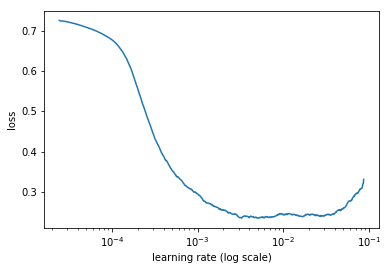

In [16]:
%matplotlib inline
FAI_model.sched.plot(100)

In [17]:
lr = 1.2e-3

In [15]:
# def accuracy(preds, y):
#     return np.equal(y,np.round(preds[:,0])).sum()/len(y)

from sklearn.metrics import mean_squared_log_error as msle, mean_squared_error as mse

In [18]:
if is_reg:
    metric=msle
else:
    metric=accuracy
FAI_model.fit(lr, n_cycle=2, wds = 1e-5, cycle_len=1, metrics=[metric])

epoch      trn_loss   val_loss   accuracy                      
    0      0.218645   0.203002   0.949485  
    1      0.208142   0.201296   0.94977                       



[0.20129649107456207, 0.9497700000381469]

In [38]:
FAI_model.fit??

# Other models

In [19]:
example_batch = next(iter(data.trn_dl))
x_cat, x_cont, ys = example_batch
x_cont[0]=np.nan
x_cat, x_cont = V(x_cat[:5]), V(x_cont[:5])

In [20]:
# ys
# test_output = torch.tensor(np.matrix([[0,100],[0,1],[0,1],[0,1]])).double()
# F.nll_loss(test_output.cuda(), ys)

In [21]:
class LinReg(nn.Module):
    def __init__(self, emb_dim, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                 y_range=None, use_bn=False, is_reg=True, is_multi=False):
        super().__init__()
        self.out_sz = out_sz
        self.n_cont = n_cont
        self.lin = nn.Linear(self.n_cont, out_sz)
        nn.init.kaiming_normal_(self.lin.weight.data)

    def forward(self, x_cat, x_cont):
        return self.lin(x_cont) #torch.log(self.lin(x_cont).float()+total_shift)

    def predict(self, is_test=True):
        data_load = data.test_dl
        to_cat = []
        for batch in iter(data_load):
            x_cat, x_cont, _ = batch
            to_cat.append(self.forward(x_cat, x_cont))
        preds = torch.cat(to_cat) #torch.exp(torch.cat(to_cat))-total_shift
        return to_np(preds)

class BiInterPool_of_NFM(nn.Module):
    def __init__(self, emb_dim, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                 y_range=None, use_bn=False, is_reg=True, is_multi=False):
        super().__init__()
        self.cat_embs = nn.ModuleList([nn.Embedding(c, emb_dim) for c, s in emb_szs])
        self.cont_embs =  nn.ModuleList([nn.Embedding(2, emb_dim) for i in range(n_cont)])
        for emb in self.cat_embs: emb_init(emb)
        for emb in self.cont_embs: emb_init(emb)
        self.n_cat = len(emb_szs)
        self.n_cont = n_cont
#         self.n_feats = self.n_cat+self.n_cont
        szs = [emb_dim]+szs
        self.lins = nn.ModuleList([
            nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: nn.init.kaiming_normal_(o.weight.data)
        self.outp = nn.Linear(szs[-1], out_sz)
        nn.init.kaiming_normal_(self.outp.weight.data)
        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn,self.y_range = use_bn,y_range
        self.is_reg = is_reg
        self.is_multi = is_multi
        
    def forward(self, x_cat, x_cont):
        if self.n_cat > 0:
            cat_emb_vecs = []
            for i,e in enumerate(self.cat_embs):
                cat_emb_vecs.append(e(x_cat[:, i]))
        if self.n_cont > 0:
            x_cont_emb_idxs = torch.where(torch.isnan(x_cont), torch.zeros(x_cont.shape).cuda(), torch.ones(x_cont.shape).cuda()).long()
#             print(x_cont_emb_idxs)
            cont_emb_vecs = []
            x_cont_clone = x_cont.clone()
            x_cont_clone[x_cont_clone != x_cont_clone]=0
#             print(x_cont_clone)
            for i, e in enumerate(self.cont_embs):
                cont_emb_vecs.append(torch.unsqueeze(x_cont_clone[:,i],1) * e(x_cont_emb_idxs[:, i]))
#                 print(e(x_cont_emb_idxs[:, i]))
        if self.n_cat > 0:
            list_of_vecs = cat_emb_vecs + cont_emb_vecs
        else:
            list_of_vecs = cont_emb_vecs
            
        mult_vec = []
        for vec in list_of_vecs:
            mult_vec.append(vec.unsqueeze(1))
        v_sets = torch.cat(mult_vec, 1)    
        bi_inter_pool = .5*(v_sets.sum(1)**2 - (v_sets**2).sum(1))
        x = bi_inter_pool
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x))
            if self.use_bn: x = b(x)
            x = d(x)
        x = self.outp(x)
        if not self.is_reg:
            if self.is_multi:
                x = F.sigmoid(x)
            else:
                x = F.log_softmax(x)
        elif self.y_range:
            x = F.sigmoid(x)
            x = x*(self.y_range[1] - self.y_range[0])
            x = x+self.y_range[0]
        return x #torch.log(x+total_shift)
    
    def predict(self, is_test=True):
        data_load = data.test_dl
        to_cat = []
        for batch in iter(data_load):
            x_cat, x_cont, _ = batch
            to_cat.append(self.forward(x_cat, x_cont))
        preds = torch.cat(to_cat)#torch.exp(torch.cat(to_cat))-total_shift
        return to_np(preds)
    
class Just_Concat_SimpNet(nn.Module):
    def __init__(self, emb_dim, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                 y_range=None, use_bn=False, is_reg=True, is_multi=False):
        super().__init__()
        self.cat_embs = nn.ModuleList([nn.Embedding(c, emb_dim) for c, s in emb_szs])
        self.cont_embs =  nn.ModuleList([nn.Embedding(2, emb_dim) for i in range(n_cont)])
        for emb in self.cat_embs: emb_init(emb)
        for emb in self.cont_embs: emb_init(emb)
        self.n_cat = len(emb_szs)
        self.n_cont = n_cont
        self.n_feats = self.n_cat+self.n_cont
        szs = [emb_dim*self.n_feats]+szs
        self.lins = nn.ModuleList([
            nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: nn.init.kaiming_normal_(o.weight.data)
        self.outp = nn.Linear(szs[-1], out_sz)
        nn.init.kaiming_normal_(self.outp.weight.data)
        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn,self.y_range = use_bn,y_range
        self.is_reg = is_reg
        self.is_multi = is_multi
        
    def forward(self, x_cat, x_cont):
        if self.n_cat > 0:
            cat_emb_vecs = []
            for i,e in enumerate(self.cat_embs):
                cat_emb_vecs.append(e(x_cat[:, i]))
        if self.n_cont > 0:
            x_cont_emb_idxs = torch.where(torch.isnan(x_cont), torch.zeros(x_cont.shape).cuda(), torch.ones(x_cont.shape).cuda()).long()
#             print(x_cont_emb_idxs)
            cont_emb_vecs = []
            x_cont_clone = x_cont.clone()
            x_cont_clone[x_cont_clone != x_cont_clone]=0
#             print(x_cont_clone)
            for i, e in enumerate(self.cont_embs):
                cont_emb_vecs.append(torch.unsqueeze(x_cont_clone[:,i],1) * e(x_cont_emb_idxs[:, i]))
#                 print(e(x_cont_emb_idxs[:, i]))
        if self.n_cat > 0:
            list_of_vecs = cat_emb_vecs + cont_emb_vecs
        else:
            list_of_vecs = cont_emb_vecs
#         print(list_of_vecs)
#         print(torch.cat(list_of_vecs, dim=1).shape)
#         print(torch.cat(list_of_vecs, dim=1))
        
        x = torch.cat(list_of_vecs, dim=1)
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x))
            if self.use_bn: x = b(x)
            x = d(x)
        x = self.outp(x)
        if not self.is_reg:
            if self.is_multi:
                x = F.sigmoid(x)
            else:
                x = F.log_softmax(x)
        elif self.y_range:
            x = F.sigmoid(x)
            x = x*(self.y_range[1] - self.y_range[0])
            x = x+self.y_range[0]
        return x #torch.log(x+total_shift)
    
    def predict(self, is_test=True):
        data_load = data.test_dl
        to_cat = []
        for batch in iter(data_load):
            x_cat, x_cont, _ = batch
            to_cat.append(self.forward(x_cat, x_cont))
        preds = torch.cat(to_cat)#torch.exp(torch.cat(to_cat))-total_shift
        return to_np(preds)
    
class NFM(nn.Module):
    def __init__(self, emb_dim, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                 y_range=None, use_bn=False, is_reg=True, is_multi=False):
        super().__init__()
        self.lin_reg = LinReg(emb_dim, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                 y_range=None, use_bn=False, is_reg=True, is_multi=False)
        self.FM = BiInterPool_of_NFM(emb_dim, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                 y_range=None, use_bn=False, is_reg=True, is_multi=False)
        
    def forward(self, x_cat, x_cont):
        lin_part = self.lin_reg.forward(x_cat, x_cont)
        fm_part = self.FM.forward(x_cat, x_cont)
        x = lin_part + fm_part
#         import ipdb; ipdb.set_trace()
        return x
    
    def predict(self, is_test=True):
        data_load = data.test_dl
        to_cat = []
        for batch in iter(data_load):
            x_cat, x_cont, _ = batch
            to_cat.append(self.forward(x_cat, x_cont))
        preds = torch.cat(to_cat) #torch.exp(torch.cat(to_cat))-total_shift
        return to_np(preds)
    
class Lin_JSN(nn.Module):
    def __init__(self, emb_dim, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                 y_range=None, use_bn=False, is_reg=True, is_multi=False):
        super().__init__()
        self.lin_reg = LinReg(emb_dim, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                 y_range=None, use_bn=False, is_reg=True, is_multi=False)
        self.JSN = Just_Concat_SimpNet(emb_dim, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                 y_range=None, use_bn=False, is_reg=True, is_multi=False)
        
    def forward(self, x_cat, x_cont):
        lin_part = self.lin_reg.forward(x_cat, x_cont)
        fm_part = self.JSN.forward(x_cat, x_cont)
        x = lin_part + fm_part
#         import ipdb; ipdb.set_trace()
        return x
    
    def predict(self, is_test=True):
        data_load = data.test_dl
        to_cat = []
        for batch in iter(data_load):
            x_cat, x_cont, _ = batch
            to_cat.append(self.forward(x_cat, x_cont))
        preds = torch.cat(to_cat) #torch.exp(torch.cat(to_cat))-total_shift
        return to_np(preds)    
    


In [28]:
# lin_reg_model = LinReg(emb_dim=emb_dim, emb_szs=emb_szs, n_cont=2, emb_drop=.05,
#                     out_sz=out_sz, szs=szs, drops=[.1,.2,.3,.4], use_bn=True, is_reg=is_reg)

# BIP_model = BiInterPool_of_NFM(emb_dim=emb_dim, emb_szs=emb_szs, n_cont=2, emb_drop=.05,
#                     out_sz=out_sz, szs=szs, drops=[.1,.2,.3,.4], use_bn=True, is_reg=is_reg)

jcsimpnet_model = Just_Concat_SimpNet(emb_dim=emb_dim, emb_szs=emb_szs, n_cont=2, emb_drop=.05,
                    out_sz=out_sz, szs=szs, drops=[.1,.2,.3,.4], use_bn=True, is_reg=is_reg)

# NFM_model = NFM(emb_dim=emb_dim, emb_szs=emb_szs, n_cont=2, emb_drop=.05,
#                     out_sz=out_sz, szs=szs, drops=[.1,.2,.3,.4], use_bn=True, is_reg=is_reg)

# Lin_JSN_model = Lin_JSN(emb_dim=emb_dim, emb_szs=emb_szs, n_cont=2, emb_drop=.05,
#                     out_sz=out_sz, szs=szs, drops=[.1,.2,.3,.4], use_bn=True, is_reg=is_reg)

# lin_reg_model.cuda()
# BIP_model.cuda()
jcsimpnet_model.cuda()
# NFM_model.cuda()
# Lin_JSN_model.cuda()

Just_Concat_SimpNet(
  (cat_embs): ModuleList(
    (0): Embedding(5, 100)
    (1): Embedding(5, 100)
  )
  (cont_embs): ModuleList(
    (0): Embedding(2, 100)
    (1): Embedding(2, 100)
  )
  (lins): ModuleList(
    (0): Linear(in_features=400, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (outp): Linear(in_features=50, out_features=2, bias=True)
  (emb_drop): Dropout(p=0.05)
  (drops): ModuleList(
    (0): Dropout(p=0.1)
    (1): Dropout(p=

In [29]:
# model.forward(x_cat, x_cont)
# list(model.parameters())

In [30]:
lin_reg_opt = optim.Adam(lin_reg_model.parameters(), 1e-2)
BIP_opt = optim.Adam(BIP_model.parameters(), 1e-2)
jcsimpnet_opt = optim.Adam(jcsimpnet_model.parameters(), 1e-2)
NFM_opt = optim.Adam(NFM_model.parameters(), 1e-2)
Lin_JSN_opt = optim.Adam(Lin_JSN_model.parameters(), 1e-2)

In [31]:
if is_reg:
    metric = F.mse_loss
else:
    metric = F.nll_loss

In [40]:
# fit(lin_reg_model, data, 2, lin_reg_opt, F.mse_loss)
# fit(BIP_model, data, 2, BIP_opt, F.mse_loss)

In [42]:
fit(jcsimpnet_model, data, 2, jcsimpnet_opt, metric)

epoch      trn_loss   val_loss                                 
    0      0.215107   0.210529  
    1      0.22027    0.209764                                 



[0.2097640064907074]

In [43]:
# fit(NFM_model, data, 2, NFM_opt, F.mse_loss)

In [44]:
# fit(Lin_JSN_model, data, 2, Lin_JSN_opt, metric)

# Validation

In [45]:
FAI_preds = FAI_model.predict(is_test=True)
# lin_reg_preds = lin_reg_model.predict(is_test=True)
# BIP_preds = BIP_model.predict(is_test=True)
jcsimpnet_preds = jcsimpnet_model.predict(is_test=True)
# NFM_preds = NFM_model.predict(is_test=True)
# Lin_JSN_preds = Lin_JSN_model.predict(is_test=True)

In [51]:
accuracy(V(np.exp(FAI_preds)), V(y))

tensor(0.9496, device='cuda:0')

In [52]:
accuracy(V(np.exp(jcsimpnet_preds)), V(y))

tensor(0.9450, device='cuda:0')

In [52]:
FAI_msle = msle(y, FAI_preds)
FAI_mse = mse(y, FAI_preds)

lin_reg_msle = msle(y, lin_reg_preds)
lin_reg_mse = mse(y, lin_reg_preds)

BIP_msle = msle(y, BIP_preds)
BIP_mse = mse(y, BIP_preds)

jcsimpnet_msle = msle(y, jcsimpnet_preds)
jcsimpnet_mse = mse(y, jcsimpnet_preds)

NFM_msle = msle(y, NFM_preds)
NFM_mse = mse(y, NFM_preds)

Lin_JSN_msle = msle(y, Lin_JSN_preds)
Lin_JSN_mse = mse(y, Lin_JSN_preds)

In [54]:
print("mean squarred log errors:")
print("FAI: {0}, \nlin_reg: {1}, \nBIP: {2} \njcsimpnet: {3} \nNFM: {4} \nLin_JSN: {5}".format(FAI_msle, lin_reg_msle, BIP_msle, jcsimpnet_msle, NFM_msle, Lin_JSN_msle))
print(" ")
print("mean squarred errors")
print("FAI: {0}, \nlin_reg: {1}, \nBIP: {2} \njcsimpnet: {3} \nNFM: {4} \nLin_JSN: {5}".format(FAI_mse, lin_reg_mse, BIP_mse, jcsimpnet_mse, NFM_mse, Lin_JSN_mse))

mean squarred log errors:
FAI: 0.01004680870191199, 
lin_reg: 0.05424115450423642, 
BIP: 0.1005453619838182 
jcsimpnet: 0.004983058384114421 
NFM: 0.0533362058012978 
Lin_JSN: 0.005842034077830897
 
mean squarred errors
FAI: 1.0611875670200361, 
lin_reg: 3.8004664867584936, 
BIP: 4.947061860060842 
jcsimpnet: 0.22716227062772304 
NFM: 3.429335428338725 
Lin_JSN: 0.3455639274289581


<IPython.core.display.Javascript object>


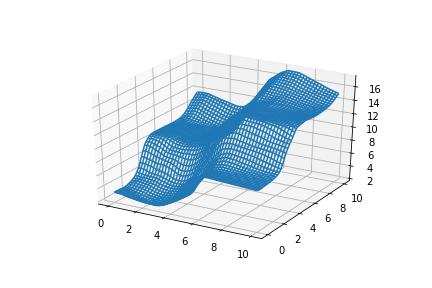

In [55]:
# FAI version
%matplotlib notebook
if is_reg:
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(X = X, Y = Y, Z = FAI_preds.reshape(X.shape))
else:
    print(accuracy(torch.tensor(preds), torch.tensor(y)))

<IPython.core.display.Javascript object>


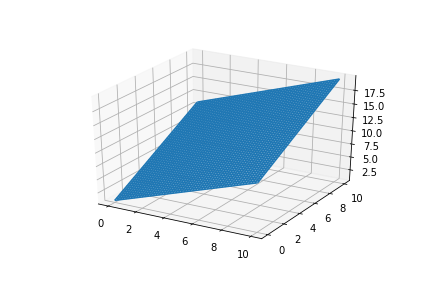

In [57]:
# just lin_reg portion
%matplotlib notebook
if is_reg:
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(X = X, Y = Y, Z = lin_reg_preds.reshape(X.shape))
else:
    print(accuracy(torch.tensor(preds), torch.tensor(y)))

<IPython.core.display.Javascript object>


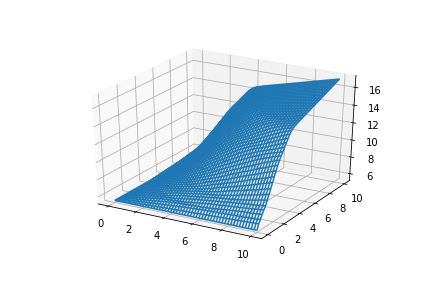

In [56]:
# just the bipoolfm portion emb_dim = 20
%matplotlib notebook
if is_reg:
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(X = X, Y = Y, Z = BIP_preds.reshape(X.shape))
else:
    print(accuracy(torch.tensor(preds), torch.tensor(y)))

<IPython.core.display.Javascript object>


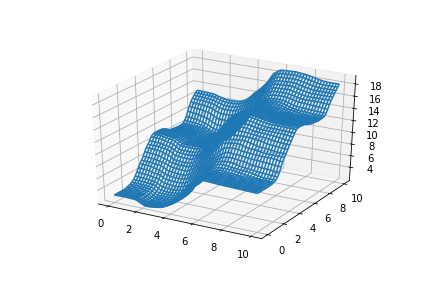

In [58]:
# jcsimpnet
%matplotlib notebook
if is_reg:
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(X = X, Y = Y, Z = jcsimpnet_preds.reshape(X.shape))
else:
    print(accuracy(torch.tensor(preds), torch.tensor(y)))

<IPython.core.display.Javascript object>


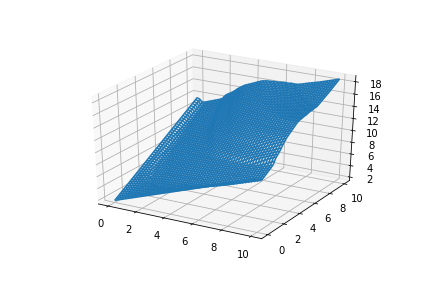

In [59]:
# full NFM
%matplotlib notebook
if is_reg:
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(X = X, Y = Y, Z = NFM_preds.reshape(X.shape))
else:
    print(accuracy(torch.tensor(preds), torch.tensor(y)))

<IPython.core.display.Javascript object>


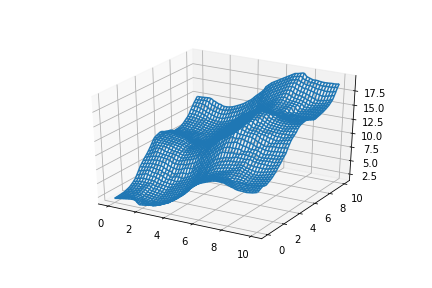

In [60]:
# Lin_JSN
%matplotlib notebook
if is_reg:
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(X = X, Y = Y, Z = Lin_JSN_preds.reshape(X.shape))
else:
    print(accuracy(torch.tensor(preds), torch.tensor(y)))

<IPython.core.display.Javascript object>


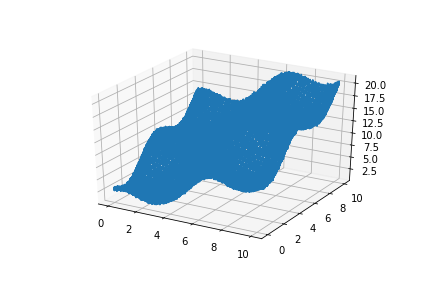

In [61]:
# actual data
%matplotlib notebook
if is_reg:
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(X = X, Y = Y, Z = y.reshape(X.shape))
else:
    print(accuracy(torch.tensor(preds), torch.tensor(y)))

## Error Analysis
```
Rules:
if df['cat1'] == 1: #error 1
    class = 1 
elif df['cont1'] < df['cont2']: #error 2
    class = 1
elif: (df['cat2'] == 0) & (df['cont1'] + df['cont2'] >=1.2): #error 3
    class = 1
else: #error 4
    class = 0
```    


## training error analysis

In [18]:
preds

array([[ 2.65721],
       [ 2.65958],
       [ 2.66196],
       [ 2.66433],
       [ 2.66657],
       [ 2.66794],
       [ 2.66931],
       [ 2.67067],
       [ 2.67204],
       [ 2.67341],
       [ 2.67469],
       [ 2.67595],
       [ 2.67722],
       [ 2.67848],
       [ 2.67974],
       [ 2.68101],
       [ 2.68227],
       [ 2.68353],
       [ 2.6848 ],
       [ 2.68606],
       ...,
       [15.95101],
       [15.94295],
       [15.93491],
       [15.9269 ],
       [15.9189 ],
       [15.9109 ],
       [15.90289],
       [15.89489],
       [15.88689],
       [15.87888],
       [15.87146],
       [15.86417],
       [15.85688],
       [15.84959],
       [15.8423 ],
       [15.83501],
       [15.82771],
       [15.82042],
       [15.81313],
       [15.80584]], dtype=float32)

In [17]:
# on train set
train_idxs = list(set(np.arange(len(df))).difference(set(val_idxs)))
train_preds = np.exp(MIM.predict(is_test=True))[train_idxs]
ex_train_preds = pd.DataFrame({'preds':np.round(train_preds[:,1]),
                             'y': y[train_idxs]})
print('train accuracy: {0}'.format((ex_train_preds['preds'] == ex_train_preds['y']).sum()/len(ex_train_preds)))
train = df.loc[train_idxs]
train['preds'] = ex_train_preds['preds'].values
train_wrong = train[train['preds'] != train['y']]
# train_wrong = df.loc[train_wrong.index,:]

train accuracy: 0.969685


KeyError: 'y'

In [ ]:
train_wrong.head()

In [60]:
def get_error(df):
    return np.where((df['cat1'] == 0) & (df['preds'] == 0), 1,
                   np.where((df['cont1'] < df['cont2']) & (df['preds'] == 0), 2, 
                            np.where(((df['cat2'] == 0) & (df['cont1'] + df['cont2'] >=1.2)) & (df['preds'] == 0), 3, 4)))
train_wrong['error_type'] = get_error(train_wrong)

/home/justin/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


```
Rules:
if df['cat1'] == 1: #error 1
    class = 1 
elif df['cont1'] < df['cont2']: #error 2
    class = 1
elif: (df['cat2'] == 0) & (df['cont1'] + df['cont2'] >=1.2): #error 3
    class = 1
else: #error 4
    class = 0
```    

In [64]:
train_wrong['error_type'].value_counts(dropna=False)

4    64
1    32
3    20
2    13
Name: error_type, dtype: int64

## validation analysis

In [100]:
# val_preds = np.exp(MIM.predict())
val_preds = predict(fm, data.val_dl)
val_preds = np.exp(val_preds)

In [101]:
ex_val_preds = pd.DataFrame({'preds':np.round(val_preds[:,1]),
                             'y': y[val_idxs]})

In [102]:
(ex_val_preds['preds'] == ex_val_preds['y']).sum()/len(ex_val_preds)

0.998255

In [99]:
ex_val_preds.head()

,preds,y
0,1.0,1
1,1.0,1
2,0.0,0
3,0.0,0
4,1.0,1


In [449]:
log_loss(y[val_idxs], val_preds)

0.1856590887054531

In [25]:
def accuracy(y, val_idxs, val_preds):
    return np.equal(y[val_idxs],np.round(val_preds[:,1])).sum()/len(val_idxs)

In [26]:
accuracy(y, val_idxs, val_preds)

0.9999902

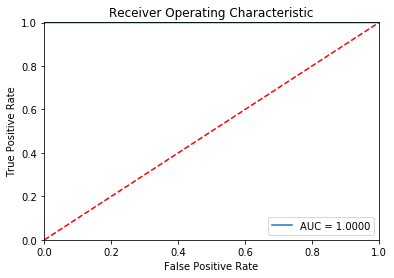

0.9999999972806534


In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

fpr, tpr, thresholds = roc_curve(y[val_idxs], val_preds[:,1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();
print(roc_auc)

# Stuff to work with later

In [ ]:
class DeepFM(nn.Module):
    def __init__(self, emb_szs, cont_emb_dim, n_cont, emb_drop, out_sz, szs, drops,
                 y_range=None, use_bn=False, is_reg=True, is_multi=False):
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c, s in emb_szs])
        self.cont_embs = nn.ModuleList(
            [nn.Embedding(1, cont_emb_dim) for i in np.arange(n_cont)])
        for emb in self.embs:
            emb_init(emb)
        n_emb = sum(e.embedding_dim for e in self.embs)
        self.n_emb, self.n_cont = n_emb, n_cont

        szs = [cont_emb_dim] + szs
        self.lins = nn.ModuleList([
            nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins:
            kaiming_normal(o.weight.data)
        self.outp = nn.Linear(szs[-1], out_sz)
        kaiming_normal(self.outp.weight.data)

        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn, self.y_range = use_bn, y_range
        self.is_reg = is_reg
        self.is_multi = is_multi

    def forward(self, x_cat, x_cont):
        # embedding and bi_inter_pool_vec
        if self.n_emb != 0:
            emb_vecs = [e(x_cat[:, i]) for i, e in enumerate(self.embs)]
        if self.n_cont != 0:
            cont_emb_vecs = [x_cont[:, i].unsqueeze(
                1)*e(V(torch.zeros(x_cont.shape[0]).long())) for i, e in enumerate(self.cont_embs)]
        all_emb_vecs = emb_vecs + cont_emb_vecs
        bi_inter_pool_vec = V(torch.ones(all_emb_vecs[0].size()))
        for combo in itertools.combinations(all_emb_vecs, 2):
            bi_inter_pool_vec += combo[0]*combo[1]
        # deep portion

        for l, d, b in zip(self.lins, self.drops, self.bns):
            bi_inter_pool_vec = F.relu(l(bi_inter_pool_vec))
            if self.use_bn:
                bi_inter_pool_vec = b(bi_inter_pool_vec)
            bi_inter_pool_vec = d(bi_inter_pool_vec)
        bi_inter_pool_vec = self.outp(bi_inter_pool_vec)
        if not self.is_reg:
            if self.is_multi:
                bi_inter_pool_vec = F.sigmoid(bi_inter_pool_vec)
            else:
                bi_inter_pool_vec = F.log_softmax(bi_inter_pool_vec)
        elif self.y_range:
            bi_inter_pool_vec = F.sigmoid(bi_inter_pool_vec)
            bi_inter_pool_vec = bi_inter_pool_vec * \
                (self.y_range[1] - self.y_range[0])
            bi_inter_pool_vec = bi_inter_pool_vec+self.y_range[0]
        return bi_inter_pool_vec
    

# reference stuff to probably delete

In [178]:
data.get_learner(emb_szs=emb_szs, n_cont=2, emb_drop=.05, out_sz=out_sz, szs = [50, 50, 50, 25], drops = [.1, .2, .3, .4], use_bn=True)

class MixedInputModel(nn.Module):
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                 y_range=None, use_bn=False, is_reg=True, is_multi=False):
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])
        for emb in self.embs: emb_init(emb)
        n_emb = sum(e.embedding_dim for e in self.embs)
        self.n_emb, self.n_cont=n_emb, n_cont
        
        szs = [n_emb+n_cont] + szs
        self.lins = nn.ModuleList([
            nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: kaiming_normal(o.weight.data)
        self.outp = nn.Linear(szs[-1], out_sz)
        kaiming_normal(self.outp.weight.data)

        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn,self.y_range = use_bn,y_range
        self.is_reg = is_reg
        self.is_multi = is_multi

    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x2 = self.bn(x_cont)
            x = torch.cat([x, x2], 1) if self.n_emb != 0 else x2
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x))
            if self.use_bn: x = b(x)
            x = d(x)
        x = self.outp(x)
        if not self.is_reg:
            if self.is_multi:
                x = F.sigmoid(x)
            else:
                x = F.log_softmax(x)
        elif self.y_range:
            x = F.sigmoid(x)
            x = x*(self.y_range[1] - self.y_range[0])
            x = x+self.y_range[0]
        return x
    
class FM(nn.Module):
    def __init__(self, cat_levels, emb_dim, n_cat, n_cont, out_sz):
        super().__init__()
        self.emb_dim, self.n_cat, self.n_cont = emb_dim, n_cat, n_cont
        self.cat_embs = nn.ModuleList([get_emb(v, emb_dim) for k, v in cat_levels])
        self.cont_embs = nn.ModuleList([get_emb(2, emb_dim) for i in np.arange(n_cont)])
        self.beg_n_feat = self.n_cat+self.n_cont
        self.fin_n_feat = int(scipy.special.comb(self.beg_n_feat,2))
        self.out_sz = out_sz
#         self.outp = nn.Linear(self.fin_n_feat, out_sz)
#         self.hl1 = nn.Linear(self.n_cat * self.emb_dim + self.n_cont, 100)
        self.hl1 = nn.Linear(self.beg_n_feat * self.emb_dim, 100)
        nn.init.kaiming_normal_(self.hl1.weight.data)
        self.bn1 = nn.BatchNorm1d(100)
        self.outp = nn.Linear(100, out_sz)

    def forward(self, x_cat, x_cont):
        if self.n_cat > 0:
            cat_emb_vecs = []
            for i,e in enumerate(self.cat_embs):
                cat_emb_vecs.append(e(x_cat[:, i]))
#             x1 = torch.cat(cat_emb_vecs,1)
        if self.n_cont > 0:
#             cont_emb_vecs = [x_cont]
#             x2 = x_cont
            x_cont_emb_idxs = torch.where(torch.isnan(x_cont), torch.zeros(x_cont.shape).cuda(), torch.ones(x_cont.shape).cuda()).long()
            cont_emb_vecs = []
            for i, e in enumerate(self.cont_embs):
                x_cont_clone = x_cont.clone()
                x_cont_clone[x_cont_clone != x_cont_clone]=0
                cont_emb_vecs.append(torch.unsqueeze(x_cont_clone[:,i],1) * e(x_cont_emb_idxs[:, i]))
        list_of_vecs = cat_emb_vecs + cont_emb_vecs
#         base_vec = torch.cat([x1, x2], 1)

#         base_vec = torch.cat(list_of_vecs,1)
        mult_vec = []
        for vec in list_of_vecs:
            mult_vec.append(vec.unsqueeze(1))
        v_sets = torch.cat(mult_vec, 1)
        import ipdb; ipdb.set_trace()
        to_concat = []
        for i in np.arange(self.beg_n_feat-1):
            temp_tensor = V(torch.matmul(v_sets[:,i,:].unsqueeze(1), v_sets[:,i+1:,: ].unsqueeze(1).permute(0,2,1)))
            tt_shape = temp_tensor.shape
            to_concat.append(temp_tensor.resize_(tt_shape[0], tt_shape[2]))
        base_vec = torch.cat(to_concat,1)

#         print(list(self.parameters()))
#         print(base_vec)

        base_vec = self.bn1(F.relu(self.hl1(base_vec)))
        return F.log_softmax(self.outp(base_vec))    

class FM(nn.Module):
    def __init__(self, cat_levels, emb_dim, n_cat, n_cont, out_sz):
        super().__init__()
        self.emb_dim, self.n_cat, self.n_cont = emb_dim, n_cat, n_cont
        self.cat_embs = nn.ModuleList([get_emb(v, emb_dim) for k, v in cat_levels])
        self.cont_embs = nn.ModuleList([get_emb(2, emb_dim) for i in np.arange(n_cont)])
        self.beg_n_feat = self.n_cat+self.n_cont
        self.fin_n_feat = int(scipy.special.comb(self.beg_n_feat,2))
        self.out_sz = out_sz
#         self.outp = nn.Linear(self.fin_n_feat, out_sz)
#         self.hl1 = nn.Linear(self.n_cat * self.emb_dim + self.n_cont, 100)
        self.hl1 = nn.Linear(self.beg_n_feat * self.emb_dim, 100)
        nn.init.kaiming_normal_(self.hl1.weight.data)
        self.bn1 = nn.BatchNorm1d(100)
        self.outp = nn.Linear(100, out_sz)

    def forward(self, x_cat, x_cont):
        if self.n_cat > 0:
            cat_emb_vecs = []
            for i,e in enumerate(self.cat_embs):
                cat_emb_vecs.append(e(x_cat[:, i]))
#             x1 = torch.cat(cat_emb_vecs,1)
        if self.n_cont > 0:
#             cont_emb_vecs = [x_cont]
#             x2 = x_cont
            x_cont_emb_idxs = torch.where(torch.isnan(x_cont), torch.zeros(x_cont.shape).cuda(), torch.ones(x_cont.shape).cuda()).long()
            cont_emb_vecs = []
            for i, e in enumerate(self.cont_embs):
                x_cont_clone = x_cont.clone()
                x_cont_clone[x_cont_clone != x_cont_clone]=0
                cont_emb_vecs.append(torch.unsqueeze(x_cont_clone[:,i],1) * e(x_cont_emb_idxs[:, i]))
        list_of_vecs = cat_emb_vecs + cont_emb_vecs
#         base_vec = torch.cat([x1, x2], 1)

#         base_vec = torch.cat(list_of_vecs,1)
        mult_vec = []
        for vec in list_of_vecs:
            mult_vec.append(vec.unsqueeze(1))
        v_sets = torch.cat(mult_vec, 1)
        import ipdb; ipdb.set_trace()
        to_concat = []
        for i in np.arange(self.beg_n_feat-1):
            temp_tensor = V(torch.matmul(v_sets[:,i,:].unsqueeze(1), v_sets[:,i+1:,: ].unsqueeze(1).permute(0,2,1)))
            tt_shape = temp_tensor.shape
            to_concat.append(temp_tensor.resize_(tt_shape[0], tt_shape[2]))
        base_vec = torch.cat(to_concat,1)

#         print(list(self.parameters()))
#         print(base_vec)

        base_vec = self.bn1(F.relu(self.hl1(base_vec)))
        return F.log_softmax(self.outp(base_vec))

/home/justin/justin_tinkering/fastai/column_data.py:101: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  for o in self.lins: kaiming_normal(o.weight.data)
/home/justin/justin_tinkering/fastai/column_data.py:103: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  kaiming_normal(self.outp.weight.data)


In [ ]:
class Embed_All(nn.Module):
    def __init__(self, emb_dim, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                 y_range=None, use_bn=False, is_reg=True, is_multi=False):
        super().__init__()
        self.cat_embs = nn.ModuleList([nn.Embedding(c, emb_dim) for c, s in emb_szs])
        self.cont_embs =  nn.ModuleList([nn.Embedding(2, emb_dim) for i in range(n_cont)])
        for emb in self.cat_embs: emb_init(emb)
        for emb in self.cont_embs: emb_init(emb)
        self.n_cat = len(emb_szs)
        self.n_cont = n_cont
        self.n_feats = self.n_cat+self.n_cont
        szs = [emb_dim*self.n_feats]+szs
        self.lins = nn.ModuleList([
            nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: nn.init.kaiming_normal_(o.weight.data)
        self.outp = nn.Linear(szs[-1], out_sz)
        nn.init.kaiming_normal_(self.outp.weight.data)
        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn,self.y_range = use_bn,y_range
        self.is_reg = is_reg
        self.is_multi = is_multi

    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
#         if self.n_cont != 0:
#             x2 = self.bn(x_cont)
#             x = torch.cat([x, x2], 1) if self.n_emb != 0 else x2
        if self.n_cont > 0:
            x_cont_emb_idxs = torch.where(torch.isnan(x_cont), torch.zeros(x_cont.shape).cuda(), torch.ones(x_cont.shape).cuda()).long()
#             print(x_cont_emb_idxs)
            cont_emb_vecs = []
            x_cont_clone = x_cont.clone()
            x_cont_clone[x_cont_clone != x_cont_clone]=0
#             print(x_cont_clone)
            for i, e in enumerate(self.cont_embs):
                cont_emb_vecs.append(torch.unsqueeze(x_cont_clone[:,i],1) * e(x_cont_emb_idxs[:, i]))
        if self.n_cat > 0:
            list_of_vecs = cat_emb_vecs + cont_emb_vecs
        else:
            list_of_vecs = cont_emb_vecs
#         print(list_of_vecs)
#         print(torch.cat(list_of_vecs, dim=1).shape)
#         print(torch.cat(list_of_vecs, dim=1))
        
        x = torch.cat(list_of_vecs, dim=1)
            
            
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x))
            if self.use_bn: x = b(x)
            x = d(x)
        x = self.outp(x)
        if not self.is_reg:
            if self.is_multi:
                x = F.sigmoid(x)
            else:
                x = F.log_softmax(x)
        elif self.y_range:
            x = F.sigmoid(x)
            x = x*(self.y_range[1] - self.y_range[0])
            x = x+self.y_range[0]
        return x